# SIR Models with Leaky Vaccination & Time-Dependent Vaccine Distribution

**About these Models** <br/>
This code implements and SIR + V model with leaky vaccination and the possibility for people to become vaccinated over time. These models assumes a heterogeneous population with structured contacts. 

**New Variables Introduced:** 

* $\theta$: The rate of vaccine distribution. This variable will have as many entries as there are population groups. The first model assumes a fixed $\theta$ for both groups.
* $\phi$: The proportion of susceptibles unwilling to receive a vaccine. The first model assumes a fixed $\phi$ for both population groups.
* $s_w$: The proportion of the population that is susceptible and willing to receive the vaccine. 
* $s_u$: The proportion of the population that is susceptible and unwilling to receive the vaccine.

**Old Variables in Use:**

* i: the proportion of infecteds in the population
* r: the proportion of recovereds in the population
* v: the proportion of vaccinated individuals in the population
* VE: vaccine effectiveness
* $\gamma$: 1 / the rate of recovery
* $\Delta t$: the size of each time step
* p: the likelihood of contracting infection given a contact
* C: the contact frequency matrix
* $\omega_n$: the proportion of group $n$ among the total population
* N: the total population size

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def update(t, delta_t, current_val, f_prime):
    return current_val + (delta_t * f_prime)

In [3]:
def su_dot(p, C, D_w, D_su, i):
    return -p * (D_su @ C @ D_w) @ i

def sw_dot(p, C, D_w, D_sw, i, theta):
    vaccinated_s = D_sw @ theta
    infected_s = p * (D_sw @ C @ D_w) @ i
    return -vaccinated_s - infected_s

def v_dot(VE, p, C, D_w, D_v, D_sw, i, theta):
    vaccinated_s = D_sw @ theta
    infected_v = ((1 - VE) * p) * (D_v @ C @ D_w) @ i
    return vaccinated_s - infected_v

def i_dot(p, C, D_w, D_su, D_sw, D_v, gamma, i, VE):
    infected_su = p * (D_su @ C @ D_w) @ i
    infected_sw = p * (D_sw @ C @ D_w) @ i
    infected_v = ((1 - VE) * p) * (D_v @ C @ D_w) @ i
    recovered_i = gamma * i
    return infected_su + infected_sw + infected_v - recovered_i

def r_dot(gamma, i):
    return gamma * i

In [4]:
def solve(su_init, sw_init, v_init, i_init, r_init, p, C, omegas, delta_t, max_time, gamma, VE, theta):
    #set up omega matrix
    #NB this is really D_w^{-1} but for simplicity in variable names it's called D_w
    D_w = np.diag([1 / w for w in omegas])

    #record keeping
    su = [su_init]
    sw = [sw_init]
    v = [v_init]
    i = [i_init]
    r = [r_init]
    t = [0]

    #solve loop
    idx = 0
    while t[idx] < max_time:
        #update D_s and D_v at each timestep
        D_su = np.diag(su[idx].flatten())
        D_sw= np.diag(sw[idx].flatten())
        D_v = np.diag(v[idx].flatten())
        
        #set up derivatives
        su_update = su_dot(p, C, D_w, D_su, i[idx])
        sw_update = sw_dot(p, C, D_w, D_sw, i[idx], theta)
        v_update = v_dot(VE, p, C, D_w, D_v, D_sw, i[idx], theta)
        i_update = i_dot(p, C, D_w, D_su, D_sw, D_v, gamma, i[idx], VE)
        r_update = r_dot(gamma, i[idx])

        #update variables
        su.append(update(t[idx], delta_t, su[idx], su_update))
        sw.append(update(t[idx], delta_t, sw[idx], sw_update))
        v.append(update(t[idx], delta_t, v[idx], v_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))

        #update time
        t.append(t[idx] + delta_t)
        idx += 1

    return su, sw, v, i, r, t

In [5]:
#set up shared initial conditions
N = 100000
VE = 0.8
gamma = 1/14
p = 0.6

t_init = 0
delta_t = 0.125
max_t = 125

i_0 = 1 / N
v_0 = 0 #assume no one is vaccinated at beginning
s0 = 1 - i_0
r_0 = 0

num_groups = 2
proportions = [0.65, 0.35]

## Homogeneous Vaccine Distribution and Hesitancy

In [6]:
#set up initial conditions
theta = 1/6
phi = 1/8

su_0 = phi * s0
sw_0 = (1 - phi) * s0

#create arrays and vectors
C = np.array([[0.8, 0.2],[0.5, 0.5]])
omegas = np.array(proportions)
theta = np.array([theta for _ in range(num_groups)]).reshape((num_groups, 1))

#compute proportion of susceptible, infected, etc for each group
su_init = np.array([su_0 for _ in range(num_groups)]).reshape((num_groups, 1))
sw_init = np.array([sw_0 for _ in range(num_groups)]).reshape((num_groups, 1))
v_init = np.array([v_0 for _ in range(num_groups)]).reshape((num_groups, 1))
i_init = np.array([i_0 for _ in range(num_groups)]).reshape((num_groups, 1))
r_init = np.array([r_0 for _ in range(num_groups)]).reshape((num_groups, 1))

#solve
su, sw, v, i, r, t = solve(su_init, sw_init, v_init, i_init, r_init, p, C, omegas, delta_t, max_t, gamma, VE, theta)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_su = np.concatenate(su, axis=1)
all_sw = np.concatenate(sw, axis=1)
all_v = np.concatenate(v, axis=1)
all_i = np.concatenate(i, axis=1)
all_r = np.concatenate(r, axis=1)

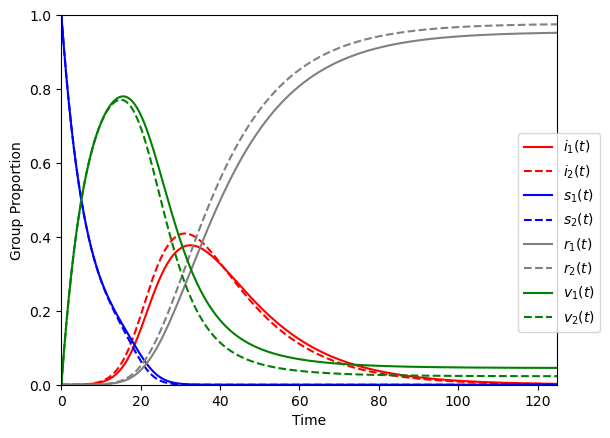

In [7]:
all_s = all_su + all_sw
plt.plot(t, all_i[0, :], color='red', label=r'$i_1(t)$')
plt.plot(t, all_i[1, :], color='red', linestyle='dashed', label=r'$i_2(t)$')
plt.plot(t, all_s[0, :], color='blue', label=r'$s_1(t)$')
plt.plot(t, all_s[1, :], color='blue', linestyle='dashed', label=r'$s_2(t)$')
plt.plot(t, all_r[0, :], color='gray', label=r'$r_1(t)$')
plt.plot(t, all_r[1, :], color='gray', linestyle='dashed', label=r'$r_2(t)$')
plt.plot(t, all_v[0, :], color='green', label=r'$v_1(t)$')
plt.plot(t, all_v[1, :], color='green', linestyle='dashed', label=r'$v_2(t)$')

plt.legend(bbox_to_anchor=(1.1, 0.7))

plt.xlim([t[0], t[-1]])
plt.ylim([0, 1])

plt.xlabel('Time')
plt.ylabel('Group Proportion')

plt.savefig('../sir_vax_adoption_homogeneous.png', dpi=200, bbox_inches='tight')
plt.show()

## Heterogeneous Vaccine Distribution and Hesitancy

In [8]:
#create arrays and vectors
C = np.array([[0.8, 0.2],[0.5, 0.5]])
omegas = np.array(proportions)
theta = np.array([1/4, 1/6]).reshape((num_groups, 1))
phis = [1/8, 1/6]

#compute proportion of susceptible, infected, etc for each group
su_init = np.array([phi * s0 for phi in phis]).reshape((num_groups, 1))
sw_init = np.array([(1 - phi) * s0 for phi in phis]).reshape((num_groups, 1))
v_init = np.array([v_0 for _ in range(num_groups)]).reshape((num_groups, 1))
i_init = np.array([i_0 for _ in range(num_groups)]).reshape((num_groups, 1))
r_init = np.array([r_0 for _ in range(num_groups)]).reshape((num_groups, 1))

#solve
su, sw, v, i, r, t = solve(su_init, sw_init, v_init, i_init, r_init, p, C, omegas, delta_t, max_t, gamma, VE, theta)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_su = np.concatenate(su, axis=1)
all_sw = np.concatenate(sw, axis=1)
all_v = np.concatenate(v, axis=1)
all_i = np.concatenate(i, axis=1)
all_r = np.concatenate(r, axis=1)

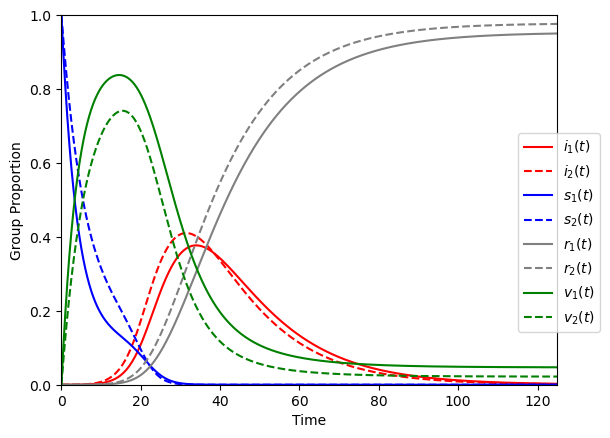

In [9]:
all_s = all_su + all_sw
plt.plot(t, all_i[0, :], color='red', label=r'$i_1(t)$')
plt.plot(t, all_i[1, :], color='red', linestyle='dashed', label=r'$i_2(t)$')
plt.plot(t, all_s[0, :], color='blue', label=r'$s_1(t)$')
plt.plot(t, all_s[1, :], color='blue', linestyle='dashed', label=r'$s_2(t)$')
plt.plot(t, all_r[0, :], color='gray', label=r'$r_1(t)$')
plt.plot(t, all_r[1, :], color='gray', linestyle='dashed', label=r'$r_2(t)$')
plt.plot(t, all_v[0, :], color='green', label=r'$v_1(t)$')
plt.plot(t, all_v[1, :], color='green', linestyle='dashed', label=r'$v_2(t)$')

plt.legend(bbox_to_anchor=(1.1, 0.7))

plt.xlim([t[0], t[-1]])
plt.ylim([0, 1])

plt.xlabel('Time')
plt.ylabel('Group Proportion')

plt.savefig('../sir_vax_adoption_heterogeneous.png', dpi=200, bbox_inches='tight')
plt.show()